In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn 
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2


BASE_PATH = "/kaggle/input/breast-cancer-semantic-segmentation-bcss/BCSS"

TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train")
TRAIN_MASK_DIR = os.path.join(BASE_PATH, "train_mask")


VAL_IMG_DIR = os.path.join(BASE_PATH, "val") 
VAL_MASK_DIR = os.path.join(BASE_PATH, "val_mask")

class BCSSDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        assert len(self.images) == len(self.masks), f"Nombre différent d'images ({len(self.images)}) et de masques ({len(self.masks)})"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path), dtype=np.uint8)

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask.long()


train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # imageNet mean and std 
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.1),
    A.GaussianBlur(blur_limit=(3, 7), p=0.1),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

train_ds = BCSSDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=train_transform)
val_ds = BCSSDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform=val_transform)


batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

print(f'Train Samples: {len(train_ds)}')
print(f'Validation Samples: {len(val_ds)}')

Train Samples: 30760
Validation Samples: 5429


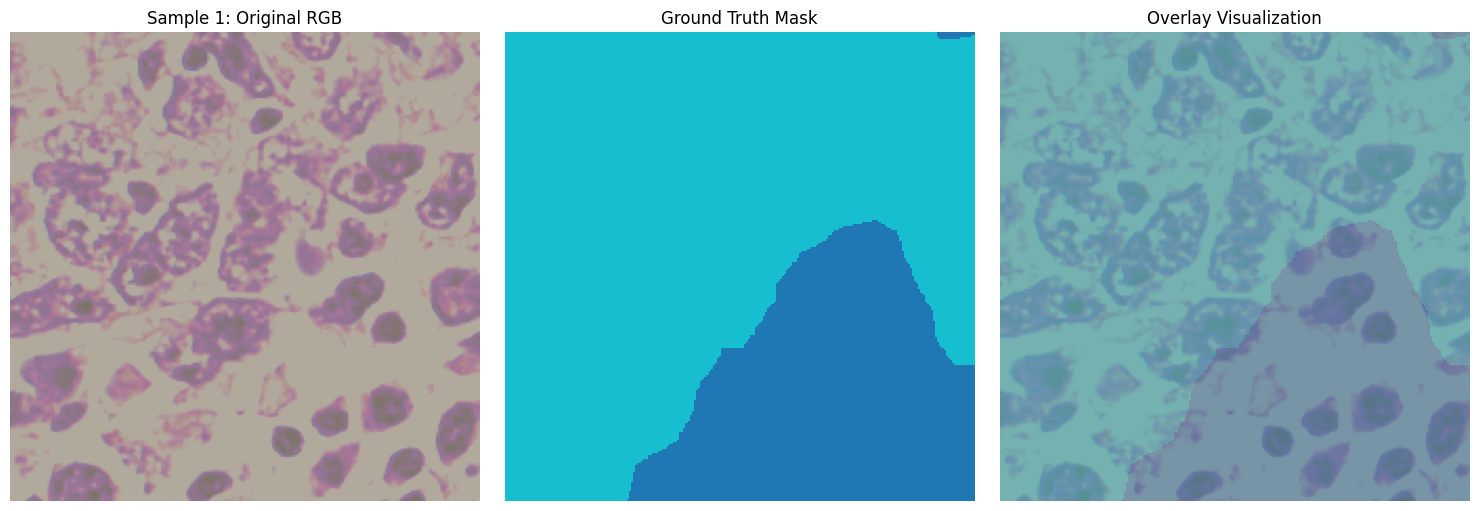

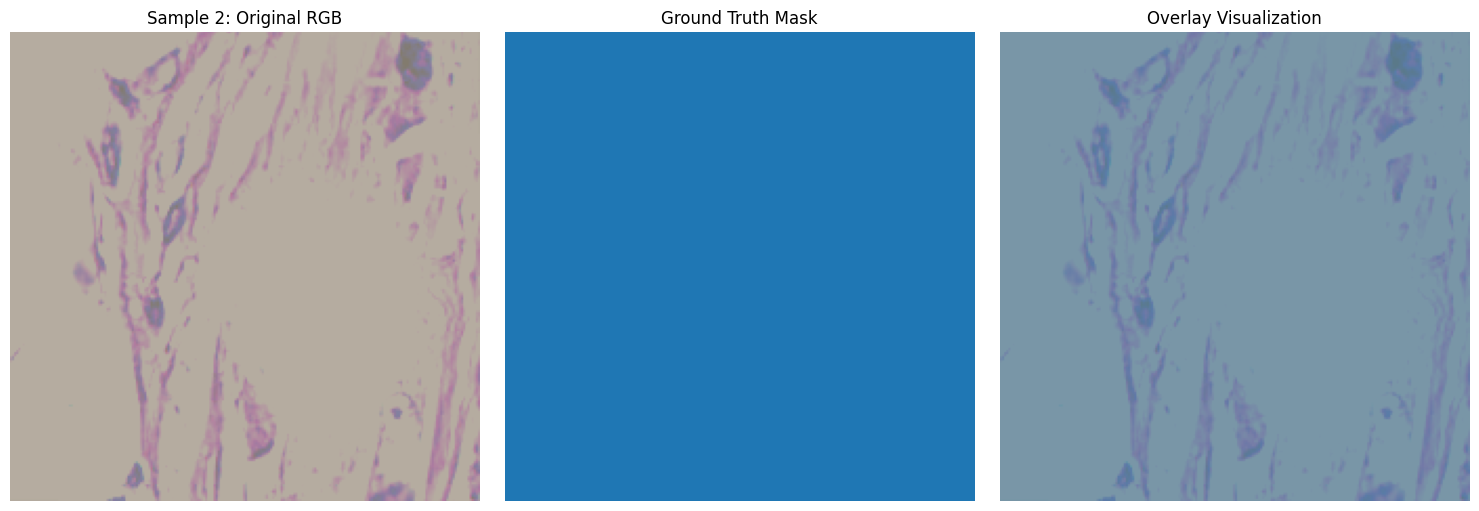

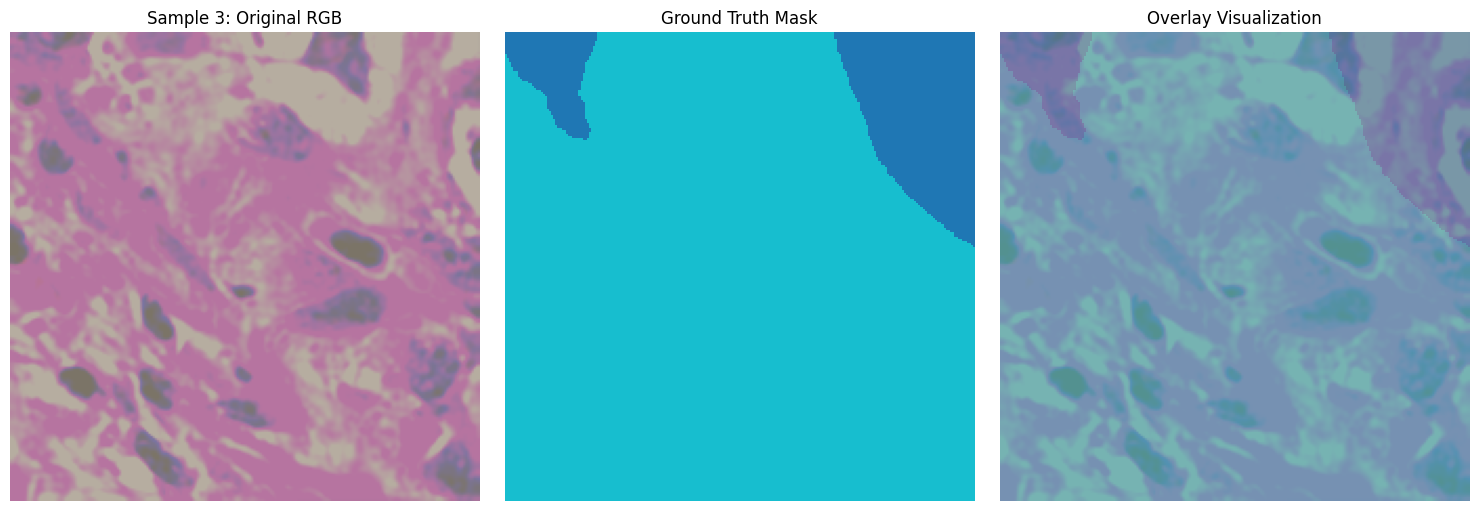

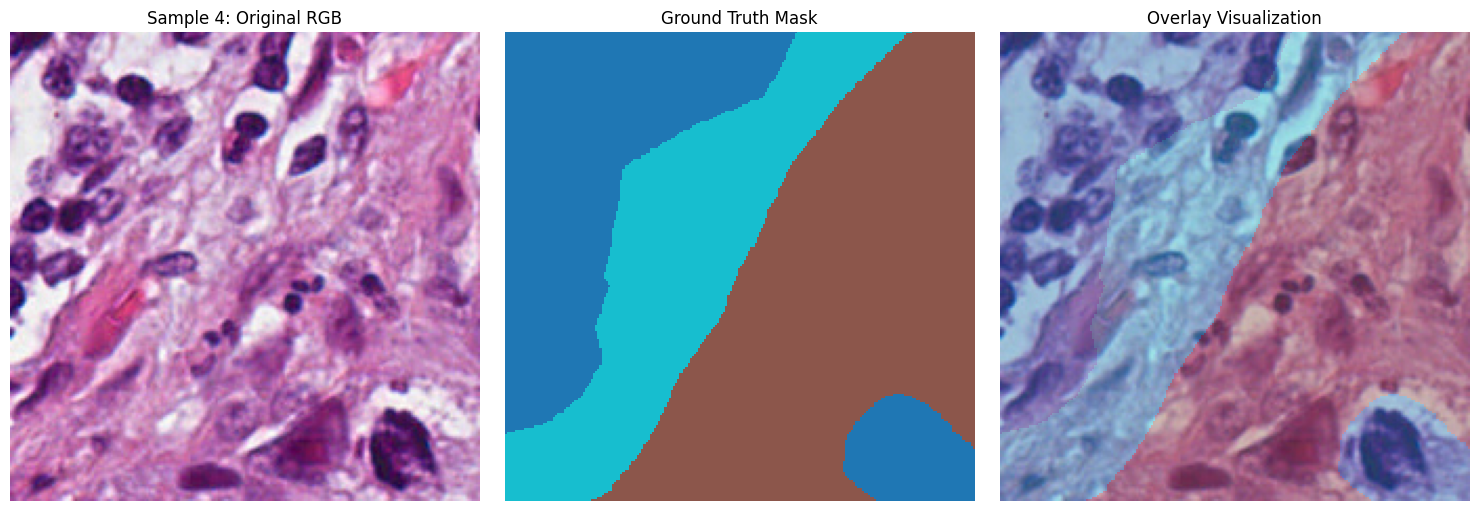

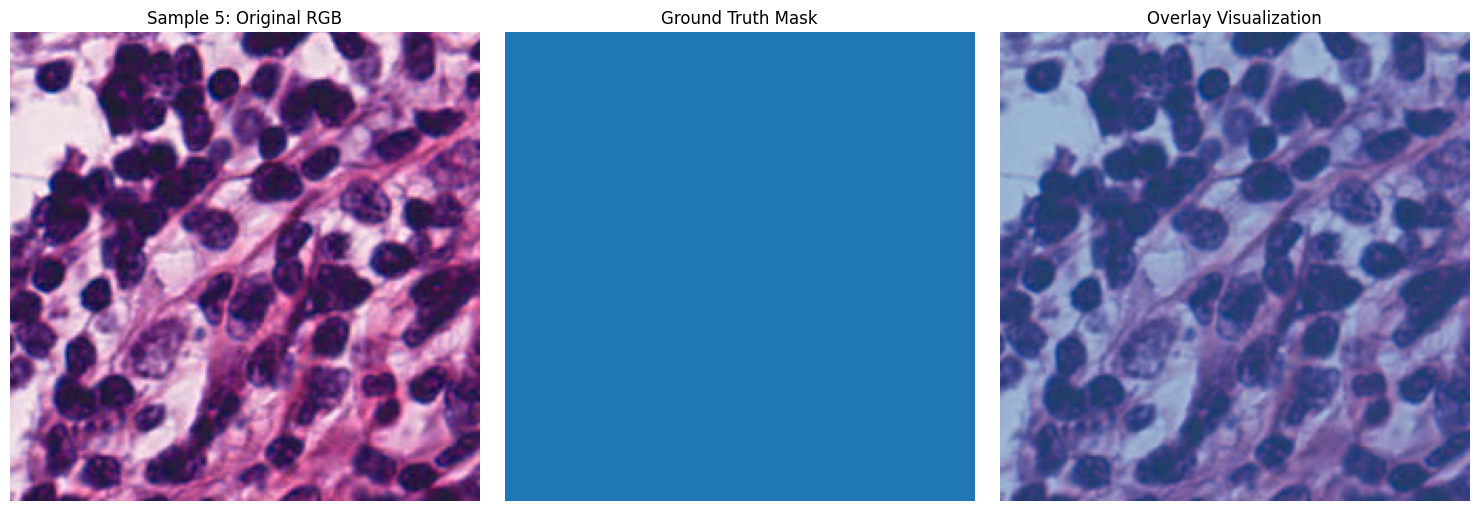

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_sample(dataloader, n_samples=1,save_dir="plots"):
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    images, masks = next(iter(dataloader))
    
    for i in range(n_samples):

        # denormalize image using mean and std from transformations 
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        mask = masks[i].cpu().numpy()

        plt.figure(figsize=(15, 5))

        # original image 
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f"Sample {i+1}: Original RGB")
        plt.axis("off")

         # segmentation mask 
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="tab10", interpolation="nearest")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        #overlay
        plt.subplot(1, 3, 3)
        plt.imshow(img)
        plt.imshow(mask, cmap="tab10", alpha=0.4, interpolation="nearest")
        plt.title("Overlay Visualization")
        plt.axis("off")

        save_path = os.path.join(save_dir, f"sample_visualization_{i+1}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.tight_layout()
        plt.show()

visualize_sample(train_loader, n_samples=5)

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(in_channels//2),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, n_filters = 32, activation=nn.ReLU()):
        super().__init__()
        
        # Config
        self.in_channels  = in_channels   
        self.out_channels = out_channels   
        self.n_filters    = n_filters  # Scaled down from 64 in original paper
        self.activation   = activation
        
        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)
        
        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d( 8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16*n_filters),
            activation,
            nn.Dropout2d(p=0.5),
            
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(8*n_filters),
            activation,
            nn.Dropout2d(p=0.5)
        )
        
        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock( 8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock( 4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock( 2*n_filters, 1*n_filters, activation)
        
        # Output projection
        self.output = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        
    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)
        
        # Bottleneck
        x      = self.bottleneck(x)
        
        # Decoder
        x      = self.upsample(x)
        x      = torch.cat((x, skip_4), axis=1)  # Skip connection
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_3), axis=1)  # Skip connection
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_2), axis=1)  # Skip connection
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_1), axis=1)  # Skip connection
        x      = self.dec_block_1(x)
        # x = self.output(x)
        logits = self.output(x)
        return logits
    
# function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels = 3, out_channels = 3)
model.to(device)

UNet(
  (activation): ReLU()
  (downsample): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_block_1): EncoderBlock(
    (encoder_block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (enc_block_2): EncoderBlock(
    (encoder_block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e

In [6]:
def dice_loss_multiclass(y_pred, y_true, smooth=1e-6):
    """
    y_pred: logits, shape [B, C, H, W]
    y_true: integer mask, shape [B, H, W]
    """
    # convert logits → probs
    y_pred = torch.softmax(y_pred, dim=1)

    # one-hot encode mask → [B, C, H, W]
    C = y_pred.shape[1]
    y_true_1hot = F.one_hot(y_true, C).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(y_pred * y_true_1hot, dims)
    union = torch.sum(y_pred + y_true_1hot, dims)

    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean() # we can ignore class 0 we just take the mean over class 1 and 2

In [7]:
def dice_score_multiclass(y_pred, y_true, smooth=1e-6, bg=False, ignore_index=255):
    """
    Robust Dice Score for High Cardinality Classes
    """
    with torch.no_grad(): 
        y_pred_idx = torch.argmax(y_pred, dim=1)
        

        valid_mask = (y_true != ignore_index)
        y_pred_idx = y_pred_idx[valid_mask]
        y_true = y_true[valid_mask]
        
        C = y_pred.shape[1]
        results = {}
        foreground_scores = [] 

        for i in range(C):
            p_mask = (y_pred_idx == i)
            t_mask = (y_true == i)

            intersection = (p_mask & t_mask).sum().float()
            union = p_mask.sum() + t_mask.sum()


            if union == 0:
                score = 1.0 # pred and ground_truth are 0，perfect !
            else:
                dice = (2 * intersection + smooth) / (union + smooth)
                score = dice.item() 

            results[f"Dice_Class_{i}"] = score

            # 4. mDice 
            if i > 0:
                foreground_scores.append(score)
            elif i == 0 and bg:
                foreground_scores.append(score)

        if len(foreground_scores) > 0:
            results["mDice"] = sum(foreground_scores) / len(foreground_scores)
        else:
            results["mDice"] = 0.0
    return results



####### mIou #######
def iou_multiclass(y_pred, y_true,smooth=1e-6,bg =False):

    y_pred_idx = torch.argmax(y_pred, dim=1)

    C = y_pred.shape[1]
    y_pred_1hot = F.one_hot(y_pred_idx, C).permute(0, 3, 1, 2).float()
    y_true_1hot = F.one_hot(y_true, C).permute(0, 3, 1, 2).float()

    class_ious = {}
    foreground_ious = []
    for i in range(C):
        # Flatten Global Batch IoU
        p = y_pred_1hot[:, i].contiguous().view(-1)
        t = y_true_1hot[:, i].contiguous().view(-1)

        intersection = (p * t).sum()
        # IoU 分母 = A + B - (A ∩ B)
        union = p.sum() + t.sum() - intersection

        if union == 0:
            iou = 1.0 # Empty target & Empty pred = Perfect
        else:
            iou_tensor = (intersection + smooth) / (union + smooth)
            iou = iou_tensor.item()

        class_ious[f"class_{i}_iou"] = iou

    # 4. Compute mIoU (Mean IoU)
    if not bg:
        foreground_ious = [v for k, v in class_ious.items() if "class_0" not in k]
    elif bg:
        foreground_ious = [v for k, v in class_ious.items()]

    if len(foreground_ious) > 0:
        m_iou = sum(foreground_ious) / len(foreground_ious)
    else:
        m_iou = 0.0
        
    class_ious["mIoU"] = m_iou
    
    return class_ious

def plot_learning_curves(train_loss, val_loss, title='--------', ylabel='Loss', save_path='./ckpt'):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    if train_loss is not None and len(train_loss) > 0:
        axis.plot([np.NaN] + train_loss, color='#636EFA', 
                  marker='o', linestyle='-', linewidth=2, 
                  markersize=5, label='Training Loss')
        
    axis.plot([np.NaN] + val_loss,   color='#EFA363', 
              marker='s', linestyle='-', linewidth=2, 
              markersize=5, label=f'Validation {ylabel}')

    # Adding title, labels and formatting
    axis.set_title(title, fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel(ylabel, fontsize=14, rotation=0, labelpad=20)

    # axis.set_ylim(0, 10)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)

    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}/{title}.png')
    plt.show()


def visualize_prediction(model, dataloader, device, num_samples=3):
    model.eval()
    inputs, targets = next(iter(dataloader))
    inputs = inputs.to(device)
    
    with torch.no_grad():
        logits = model(inputs)
        preds = torch.argmax(logits, dim=1) # [B, H, W]
        
    # Turn to CPU
    inputs = inputs.cpu()
    targets = targets.cpu()
    preds = preds.cpu()
    
    # Plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    for i in range(num_samples):
        # Original figure
        # Suppose inputs is [C, H, W]
        img = inputs[i].permute(1, 2, 0).numpy()
        # Process range
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(targets[i], cmap='jet', vmin=0, vmax=2)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(preds[i], cmap='jet', vmin=0, vmax=2)
        axes[i, 2].set_title("Model Prediction")
        axes[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

def display_test_sample(model, test_input, test_target, device):
    model.eval()
    test_input, test_target = test_input.to(device), test_target.to(device)

    with torch.no_grad():
        logits = model(test_input)
        probs = torch.softmax(logits, dim=1)                # [B, C, H, W]
        pred_mask = torch.argmax(probs, dim=1)              # [B, H, W]

    # convert to numpy
    image       = test_input[0].detach().cpu().permute(1,2,0).numpy()
    gt_mask     = test_target[0].detach().cpu().numpy()
    pred_mask   = pred_mask[0].detach().cpu().numpy()

    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'
    plt.figure(figsize=(15,5))

    # image
    plt.subplot(1,3,1)
    plt.title("H&E Image")
    plt.imshow(image.astype(np.uint8))
    plt.axis("off")

    # GT mask
    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask, cmap="tab20")
    plt.axis("off")

    # pred mask
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="tab20")
    plt.axis("off")

    plt.show()

    # overlay 
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.title("Overlay: Ground Truth")
    plt.imshow(image.astype(np.uint8))
    plt.imshow(gt_mask, cmap="tab20", alpha=0.35)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Overlay: Prediction")
    plt.imshow(image.astype(np.uint8))
    plt.imshow(pred_mask, cmap="tab20", alpha=0.35)
    plt.axis("off")

    plt.show()
import matplotlib.pyplot as plt


def show_class_mapping(dataset, index=0):
    image, mask = dataset[index]
    
    # Change format
    if hasattr(image, 'permute'):
        image = image.permute(1, 2, 0).numpy() # (C, H, W) -> (H, W, C)
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()

    # show for three class
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original figure 
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    
    # Class 0 ( Usually background )
    ax[1].imshow(mask == 0, cmap='gray')
    ax[1].set_title("Class 0 (Background?)")
    
    # Class 1 
    ax[2].imshow(mask == 1, cmap='gray')
    ax[2].set_title("Class 1 (Tumor?)")
    
    # Class 2 
    ax[3].imshow(mask == 2, cmap='gray')
    ax[3].set_title("Class 2 (Stroma?)")
    
    plt.show()


In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_dataloader, val_dataloader, config, verbose=True, loss_fn=nn.CrossEntropyLoss()):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    lr_decay_factor = config['lr_decay_factor']
    save_dir = config['save_dir']
    model_name = config['model']

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=3)
    scaler = GradScaler()

    loss_ce = loss_fn
    loss_dice = dice_loss_multiclass

    history = {
        'train_ce_loss': [], 'train_dice_loss': [], 'train_total_loss': [],
        'val_ce_loss': [], 'val_dice_loss': [], 'val_total_loss': [], 'val_mDice': []
    }

    best_val_loss = float('inf')
    print("Starting Training...")

    for epoch in range(1, n_epochs + 1):
        # ----------------------
        # Training Phase
        # ----------------------
        model.train()
        train_running_loss = 0
        train_running_dice_loss = 0

        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader):
            train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                train_preds = model(train_inputs)
                train_ce_loss = loss_ce(train_preds, train_targets)
                train_dice_loss = loss_dice(train_preds, train_targets)
                total_loss = train_ce_loss + train_dice_loss

            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_running_loss += train_ce_loss.item()
            train_running_dice_loss += train_dice_loss.item()

        # Compute Epoch average Loss
        avg_train_ce_loss = train_running_loss / len(train_dataloader)
        avg_train_dice_loss = train_running_dice_loss / len(train_dataloader)
        avg_train_total_loss = avg_train_ce_loss + avg_train_dice_loss

        history['train_ce_loss'].append(avg_train_ce_loss)
        history['train_dice_loss'].append(avg_train_dice_loss)
        history['train_total_loss'].append(avg_train_total_loss)

        # Validation Phase
        model.eval()
        val_running_loss = 0
        val_running_dice_loss = 0
        val_running_mDice = 0

        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_preds = model(val_inputs)
                val_ce_loss = loss_ce(val_preds, val_targets)
                val_dice_loss = loss_dice(val_preds, val_targets)
                val_running_loss += val_ce_loss.item()
                val_running_dice_loss += val_dice_loss.item()
                metrics = dice_score_multiclass(val_preds, val_targets)
                val_running_mDice += metrics['mDice']

        avg_val_ce_loss = val_running_loss / len(val_dataloader)
        avg_val_dice_loss = val_running_dice_loss / len(val_dataloader)
        avg_val_mDice = val_running_mDice / len(val_dataloader)
        avg_val_total_loss = avg_val_ce_loss + avg_val_dice_loss

        history['val_ce_loss'].append(avg_val_ce_loss)
        history['val_dice_loss'].append(avg_val_dice_loss)
        history['val_total_loss'].append(avg_val_total_loss)
        history['val_mDice'].append(avg_val_mDice)

        os.makedirs(save_dir, exist_ok=True)

        # Judge best model
        if avg_val_total_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            best_model_path = os.path.join(save_dir, f"{model_name}_best.pth")
            try:
                save_model(model, best_model_path)
            except NameError:
                torch.save(model.state_dict(), best_model_path)

        scheduler.step(avg_val_total_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Print ONCE per epoch (si verbose)
        if verbose:
            print(f"Epoch {epoch:2d}/{n_epochs} | LR: {current_lr:.6f} | "
                  f"Train: {avg_train_total_loss:.4f} | Val: {avg_val_total_loss:.4f} | mDice: {avg_val_mDice:.4f}")

    print("Training complete.")
    return history



/tmp/ipykernel_90/3981613708.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting Training...
Epoch  1/15 | LR: 0.005000 | Train: 1.4734 | Val: 1.3554 | mDice: 0.6318
Epoch  2/15 | LR: 0.005000 | Train: 1.3913 | Val: 1.2994 | mDice: 0.6807
Epoch  3/15 | LR: 0.005000 | Train: 1.3198 | Val: 1.2189 | mDice: 0.6918
Epoch  4/15 | LR: 0.005000 | Train: 1.2699 | Val: 1.1814 | mDice: 0.7114
Epoch  5/15 | LR: 0.005000 | Train: 1.2287 | Val: 1.1137 | mDice: 0.7194
Epoch  6/15 | LR: 0.005000 | Train: 1.1992 | Val: 1.0923 | mDice: 0.7320
Epoch  7/15 | LR: 0.005000 | Train: 1.1705 | Val: 1.0911 | mDice: 0.7179
Epoch  8/15 | LR: 0.005000 | Train: 1.1482 | Val: 1.0710 | mDice: 0.7385
Epoch  9/15 | LR: 0.005000 | Train: 1.1345 | Val: 1.0313 | mDice: 0.7518
Epoch 10/15 | LR: 0.005000 | Train: 1.1236 | Val: 1.0216 | mDice: 0.7536
Epoch 11/15 | LR: 0.005000 | Train: 1.1070 | Val: 1.0326 | mDice: 0.7508
Epoch 12/15 | LR: 0.005000 | Train: 1.0987 | Val: 1.0098 | mDice: 0.7512
Epoch 13/15 | LR: 0.005000 | Train: 1.0906 | Val: 1.0098 | mDice: 0.7572
Epoch 14/15 | LR: 0.005000 | T

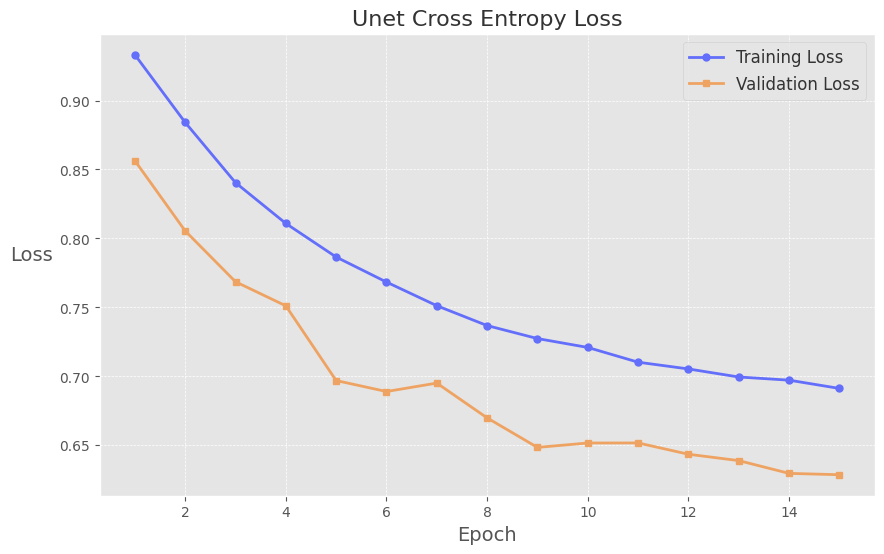

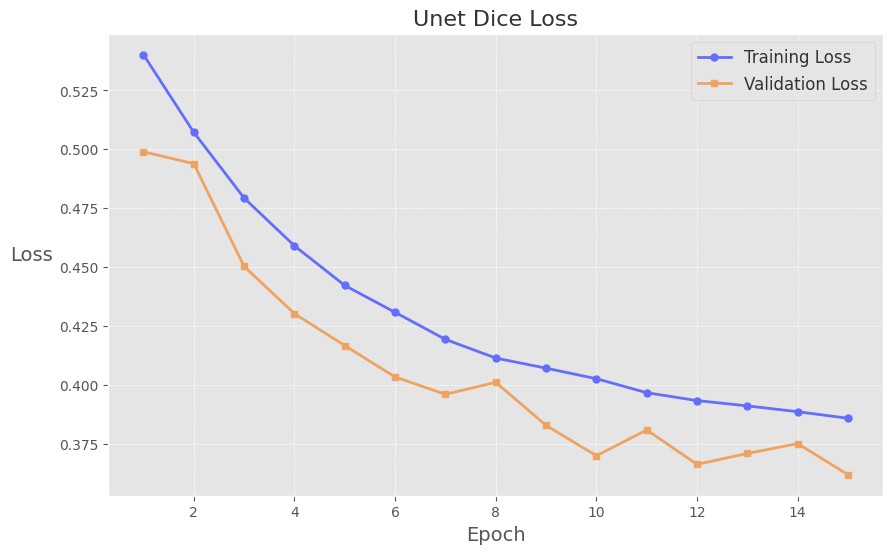

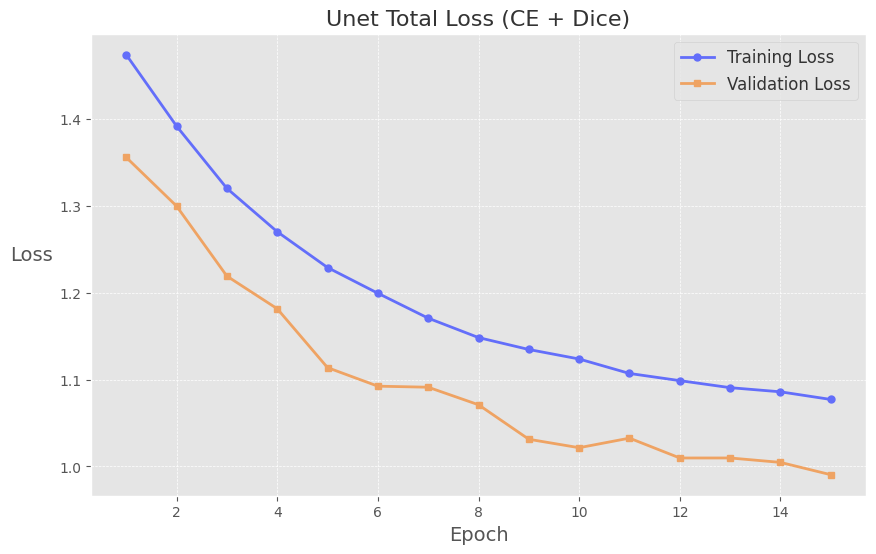

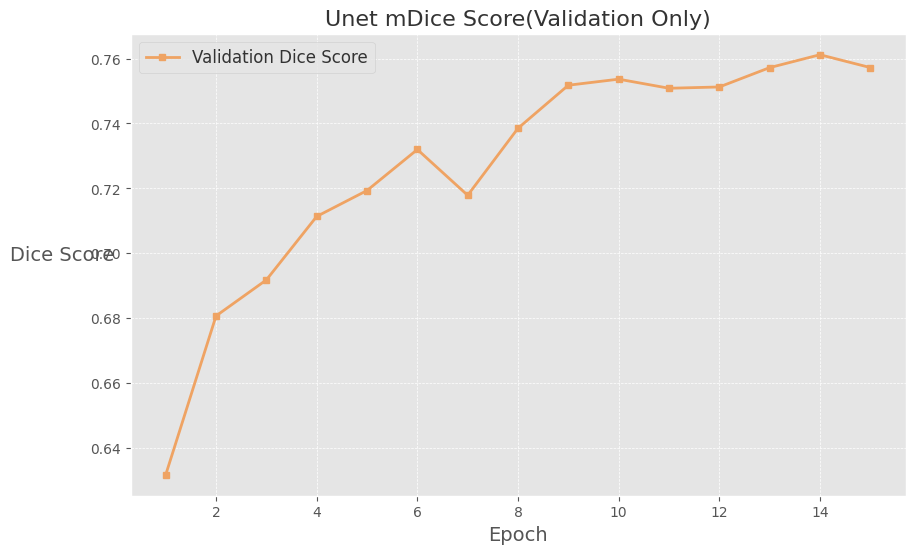

In [12]:
from tqdm import tqdm

train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 15,
    'batch_size': 128,
    'learning_rate': 5e-3,
    'lr_decay_factor': 0.85,
    'model': 'Unet',
    'save_dir': './checkpoints/',
    'output_channels': 3,
    'n_filters': 32
}


training_history = train_model(model, train_loader, val_loader, train_config, verbose=True)

if not os.path.exists(train_config["save_dir"]):
    os.makedirs(train_config["save_dir"], exist_ok=True)
    # Save weights

save_model(model, f'{train_config["save_dir"]}{train_config["model"]}-weights_last.pth')

plot_learning_curves(training_history['train_ce_loss'], 
                     training_history['val_ce_loss'], 
                     title = f'{train_config["model"]} Cross Entropy Loss',
                     save_path=train_config["save_dir"],
                     ylabel='Loss'
                     )


plot_learning_curves(training_history['train_dice_loss'], 
                        training_history['val_dice_loss'], 
                        title = f'{train_config["model"]} Dice Loss',
                        save_path=train_config["save_dir"],
                        ylabel='Loss')


plot_learning_curves(training_history['train_total_loss'], 
                        training_history['val_total_loss'], 
                        title = f'{train_config["model"]} Total Loss (CE + Dice)',
                        save_path=train_config["save_dir"],
                        ylabel='Loss'
                        )


plot_learning_curves(None, 
                        training_history['val_mDice'], 
                        save_path=train_config["save_dir"],
                        title = f'{train_config["model"]} mDice Score(Validation Only)',
                        ylabel='Dice Score'
                        )


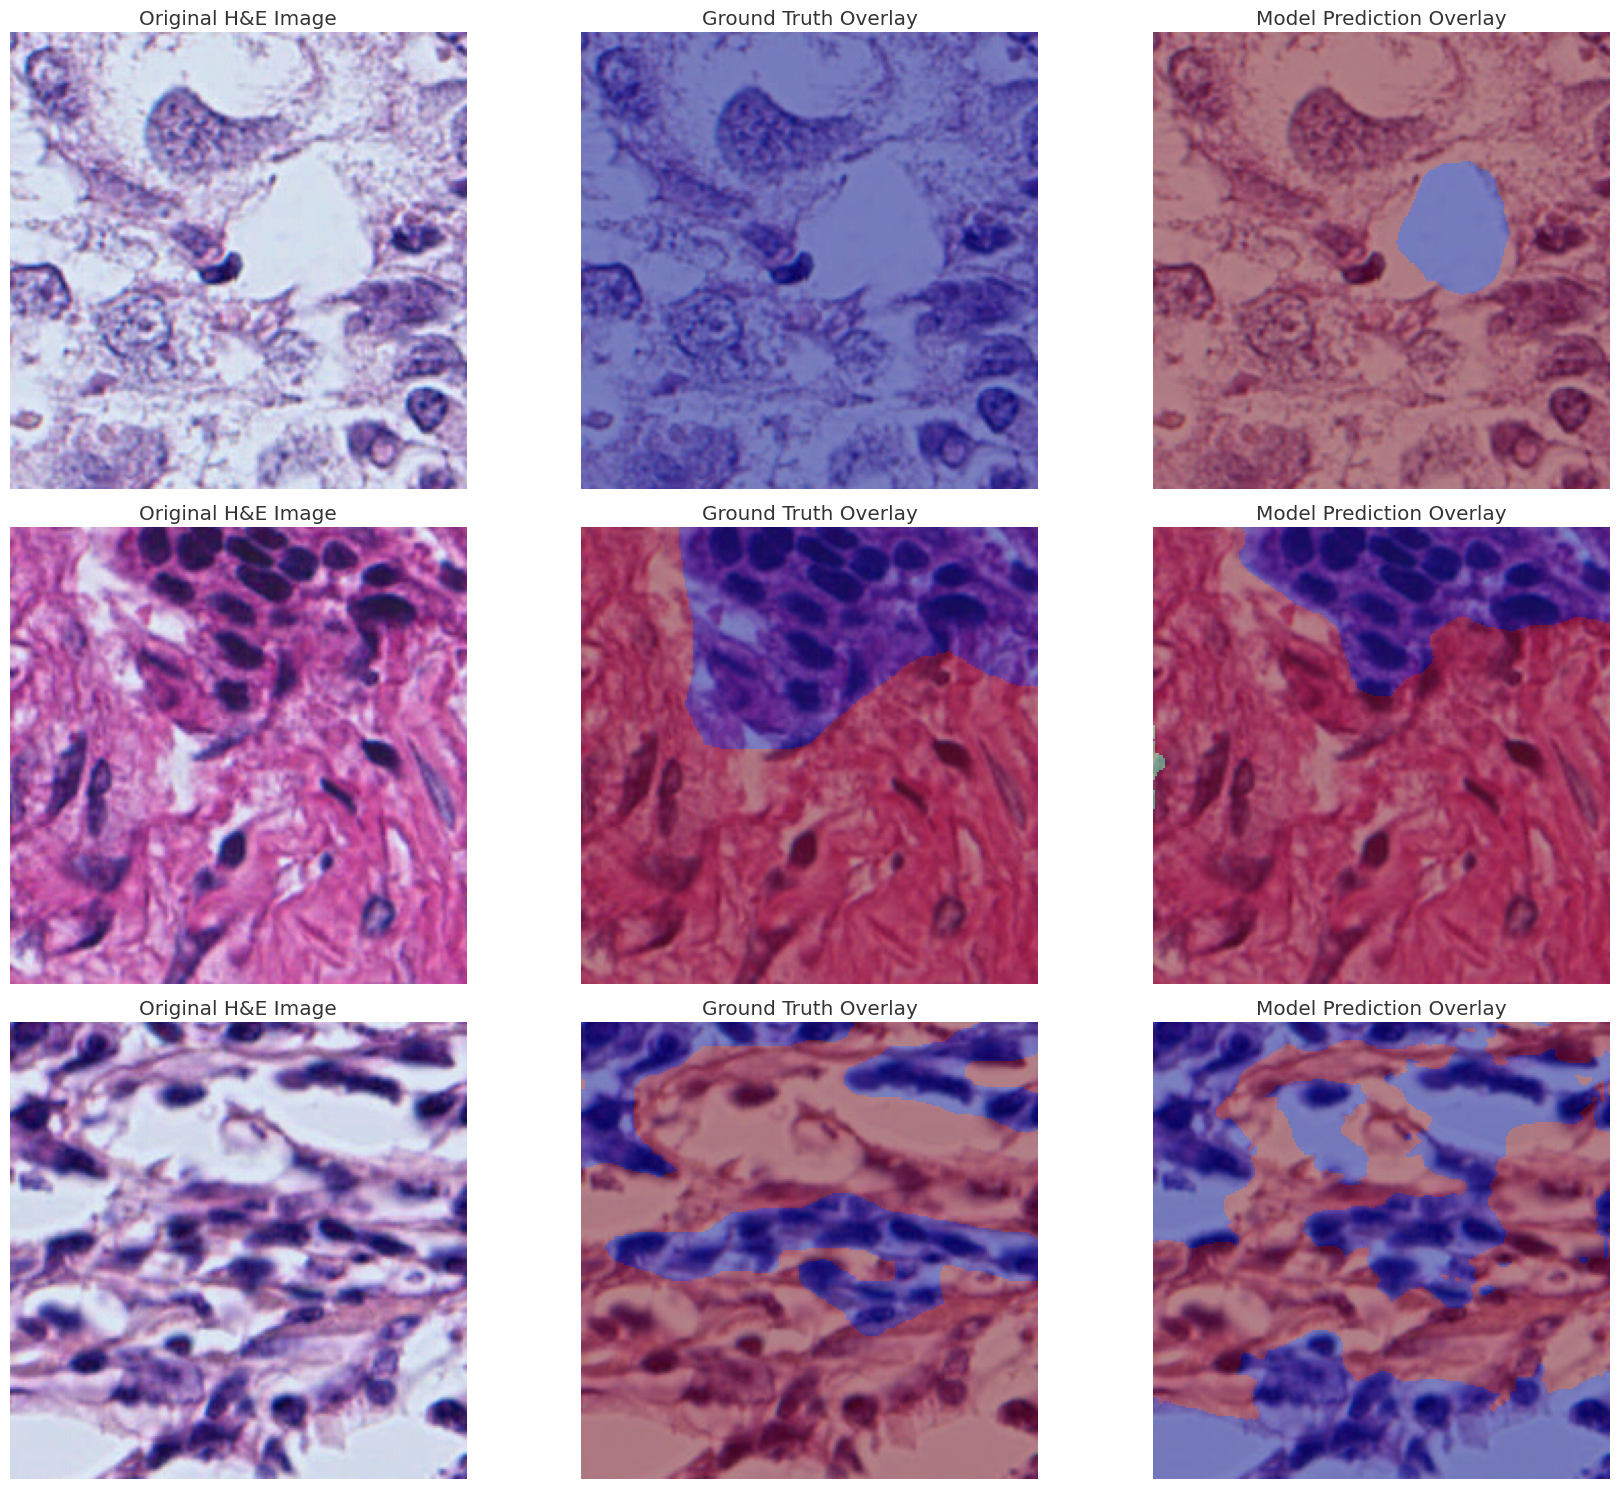

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_with_overlay(model, dataloader, device, num_samples=3, alpha=0.4):
    model.eval()
    # Récupérer un batch
    images, masks = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 5 * num_samples))
    
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        
        gt = masks[i].numpy()
        pred = preds[i].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original H&E Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img)
        axes[i, 1].imshow(gt, cmap='jet', alpha=alpha, interpolation='nearest')
        axes[i, 1].set_title("Ground Truth Overlay")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(img)
        axes[i, 2].imshow(pred, cmap='jet', alpha=alpha, interpolation='nearest')
        axes[i, 2].set_title("Model Prediction Overlay")
        axes[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_with_overlay(model, val_loader, train_config['device'], num_samples=3, alpha=0.45)

In [27]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, 
                 drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, 
                                           attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TransUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22, embed_dim=768, depth=12, 
                 num_heads=12, mlp_ratio=4., qkv_bias=True, drop_rate=0.1,
                 image_size=320):
        super().__init__()
        
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.patch_size = 16
        patches_size = (image_size // 4 // self.patch_size) ** 2
        
        self.patch_embed = nn.Sequential(
            nn.Conv2d(64, embed_dim, kernel_size=self.patch_size, stride=self.patch_size),
            Rearrange('b c h w -> b (h w) c'),
            nn.LayerNorm(embed_dim)
        )
        
        self.pos_embed = nn.Parameter(torch.zeros(1, patches_size, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=drop_rate
            )
            for _ in range(depth)
        ])
        
        self.decoder_channels = (256, 128, 64, 32)
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(embed_dim if i == 0 else self.decoder_channels[i-1],
                                   self.decoder_channels[i],
                                   kernel_size=2,
                                   stride=2),
                nn.BatchNorm2d(self.decoder_channels[i]),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.decoder_channels[i], self.decoder_channels[i],
                          kernel_size=3, padding=1),
                nn.BatchNorm2d(self.decoder_channels[i]),
                nn.ReLU(inplace=True)
            )
            for i in range(4)
        ])
        
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        
        input_size = (x.shape[2], x.shape[3]) 
        
        x = self.cnn_encoder(x)
        x = self.patch_embed(x)
        x = self.pos_drop(x + self.pos_embed)
        
        for block in self.transformer_blocks:
            x = block(x)
            
        B, N, C = x.shape
        H = W = int(N ** 0.5)
        x = x.transpose(1, 2).reshape(B, C, H, W)
        
        for decoder_block in self.decoder:
            x = decoder_block(x)
            
        x = self.final_conv(x)
    
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)
        
        return x